In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf

image_dir = '../input/fruits/fruits-360/Training'
batch_size = 128
image_size = (100, 100)
seed = 42
validation_split = .25

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    image_dir,
    labels='inferred',
    batch_size=batch_size,
    image_size=image_size,
    seed=seed,
    validation_split=validation_split,
    subset='training'
)
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    image_dir,
    labels='inferred',
    batch_size=batch_size,
    image_size=image_size,
    seed=seed,
    validation_split=validation_split,
    subset='validation'
)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '../input/fruits/fruits-360/Test',
    labels='inferred',
    batch_size=batch_size,
    image_size=image_size
)

Found 67692 files belonging to 131 classes.
Using 50769 files for training.
Found 67692 files belonging to 131 classes.
Using 16923 files for validation.
Found 22688 files belonging to 131 classes.


In [3]:
from tensorflow.keras import layers

model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(scale=1./255, input_shape=image_size+(3,)),
    layers.experimental.preprocessing.RandomFlip('horizontal'),
    layers.experimental.preprocessing.RandomRotation(.5),
    layers.Conv2D(filters=64, kernel_size=5, activation='relu', padding='same'),
    layers.MaxPool2D(),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dropout(.3),
    layers.Dense(units=128),
    layers.LeakyReLU(alpha=.3),
    layers.Dropout(.3),
    layers.Dense(units=131, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 100, 100, 3)       0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 100, 100, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 64)      4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 128)       0

In [4]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        min_delta=.001,
        patience=7,
        restore_best_weights=True
    )
]
model.compile(
    optimizer='Adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=60,
    callbacks=callbacks
)

Epoch 1/60
397/397 [==============================] - 485s 1s/step - loss: 2.8316 - accuracy: 0.3225 - val_loss: 0.2366 - val_accuracy: 0.9378
Epoch 2/60
397/397 [==============================] - 245s 617ms/step - loss: 0.3927 - accuracy: 0.8812 - val_loss: 0.0852 - val_accuracy: 0.9744
Epoch 3/60
397/397 [==============================] - 246s 618ms/step - loss: 0.1970 - accuracy: 0.9351 - val_loss: 0.0706 - val_accuracy: 0.9758
Epoch 4/60
397/397 [==============================] - 246s 618ms/step - loss: 0.1261 - accuracy: 0.9567 - val_loss: 0.0346 - val_accuracy: 0.9885
Epoch 5/60
397/397 [==============================] - 246s 619ms/step - loss: 0.1272 - accuracy: 0.9586 - val_loss: 0.0230 - val_accuracy: 0.9922
Epoch 6/60
397/397 [==============================] - 246s 619ms/step - loss: 0.0852 - accuracy: 0.9710 - val_loss: 0.0197 - val_accuracy: 0.9936
Epoch 7/60
397/397 [==============================] - 246s 619ms/step - loss: 0.0798 - accuracy: 0.9732 - val_loss: 0.0133 - va

<AxesSubplot:>

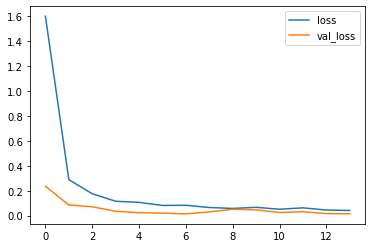

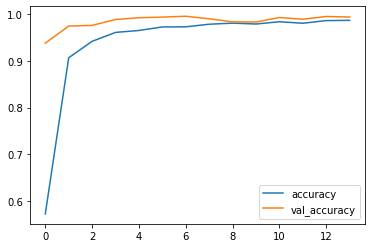

In [5]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

In [6]:
evaluation_stats = model.evaluate(test_dataset)
for metric, val in zip(model.metrics_names, evaluation_stats):
    print('{}: {}'.format(metric, val))

178/178 [==============================] - 177s 960ms/step - loss: 0.1719 - accuracy: 0.9711
loss: 0.17189645767211914
accuracy: 0.9710860252380371
